## Import Packages

In [41]:
import json, re
from tqdm import tqdm_notebook as tqdm
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer
from textblob import TextBlob
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
sns.color_palette('pastel')

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

## Import Data

In [5]:

in_paths = ['../microbiome_patents', '../probiotic_patents']
if (len(in_paths) == 1) or (isinstance(in_paths, str)):
    with open(f'{in_path}.json', 'r') as f:
        patent_data = json.load(f)
elif len(in_paths) > 1:
    patent_data = {}
    for in_path in in_paths:
        with open(f'{in_path}.json', 'r') as f:
            tmp_data = json.load(f)
        patent_data.update(tmp_data)

patent_ids = [i for i in list(patent_data.keys())]
terms = [i.split('_')[0] for i in patent_ids]
print('Terms found in the data include:', set(terms), '\n')
for term in set(terms):
    term_ids = [i.split('_')[1] for i in patent_ids if i.split('_')[0] == term]
    print(f'Minimum {term} patent result number : {min(term_ids)}\nMaximum {term} patent result number : {max(term_ids)}')


Terms found in the data include: {'probiotic', 'microbiome'} 

Minimum probiotic patent result number : 000001
Maximum probiotic patent result number : 001100
Minimum microbiome patent result number : 000001
Maximum microbiome patent result number : 001084


## Publication Dates

In [24]:
### Taken from other notebook
pub_dates = [i['publication_date'] for i in patent_data.values() if i['publication_date'] != '']
pub_dates = [i.replace('rch', 'Mar').replace('ary', 'Feb').replace('ust', 'Aug') for i in pub_dates]
pub_dates = [i.replace('ril', 'Apr').replace('une', 'Jun').replace('uly', 'Jul') for i in pub_dates]
### One could argue this substitution but the effect is minor
pub_dates = [i.replace('ber', 'Oct') for i in pub_dates]
#pub_dates = [i.replace('ber', 'Nov') for i in pub_dates]
pub_dates = [dt.datetime.strptime(i, '%b %d, %Y') for i in pub_dates]
pub_quarters = [str(i.year) + '-' + f'{pd.Timestamp(i).quarter}' for i in pub_dates]

## Abstracts

### Text pre-processing


In [8]:
abstracts = [i['abstract'].lower() for i in patent_data.values()]
abstracts = [re.sub('[,;#()-:]|(\.)|(\.$)', '', i) for i in abstracts]
abstracts[0]

'a sporeforming bacillus species and more particularly a bacillus subtilis strain identified as mb is provided compositions comprising the mb strain methods of making products comprising the same and methods of using the same are also provided'

### Word / N-Gram Tokenization

In [15]:
stop_words = set(stopwords.words('english')) 
fil_abstracts = []
corpus = []
ngrams_2 = []
ngrams_3 = []
st = PorterStemmer()

for abstract in tqdm(abstracts, total=len(abstracts)):
    word_tokens = word_tokenize(abstract)

    filtered_abstract = [st.stem(w) for w in word_tokens if not w in stop_words]
    corpus += filtered_abstract
    ngram_2 = TextBlob(' '.join(filtered_abstract)).ngrams(2)
    ngram_3 = TextBlob(' '.join(filtered_abstract)).ngrams(3)
    
    ngrams_2.append(['_'.join(list(i)) for i in ngram_2])
    ngrams_3.append(['_'.join(list(i)) for i in ngram_3])
    
    fil_abstracts.append(filtered_abstract)
    
corpus = list(set(corpus))
corpus_2grams = list(set([item for sublist in ngrams_2 for item in sublist]))
corpus_3grams = list(set([item for sublist in ngrams_3 for item in sublist]))

### N-Gram Frequencies

In [25]:
### Term Frequency across all abstracts
freq_dict = {}
df_dicts = {}
idf_dicts = {}
tfidf_dicts = {}

for ngram, list_of_grams in [('1', fil_abstracts), ('2', ngrams_2), ('3', ngrams_3)]:
    freq_dict = {}
    for abstract_words in list_of_grams:
        for word in abstract_words:
            if word not in freq_dict.keys():
                freq_dict[word] = 1
            else:
                freq_dict[word] += 1
    freq_dicts[ngram] = freq_dict

    ### Document Frequency counting number of abstracts a word appears in
    df_dict = {}
    for abstract_words in list_of_grams:
        for word in set(abstract_words):
            if word not in df_dict.keys():
                df_dict[word] = 1
            else:
                df_dict[word] += 1
    df_dicts[ngram] = df_dict
    
    idf_dict = {}
    tfidf_dict = {}
    for word in df_dict.keys():
        idf_dict[word] = np.log(len(list_of_grams) / df_dict[word])
    
    idf_dicts[ngram] = idf_dict
    

### N-Gram Analysis

#### 1-Grams

##### Top 1-Gram Lists

In [27]:
n = 25
top_term_list = sorted(freq_dicts['1'], key=freq_dicts['1'].get, reverse=True)[:n]
top_term_count_list = [freq_dicts['1'][i] for i in top_term_list]

n = 25
top_df_list = sorted(df_dicts['1'], key=df_dicts['1'].get, reverse=True)[:n]
top_df_count_list = [df_dicts['1'][i] for i in top_term_list]

##### 1-Gram Year-Quarter Corpuses

Now I'll go abstract by abstract and essentially build a corpus for each year-quarter. 

In [28]:
ab_text_year_quarter = {}
ab_count_year_quarter = {}
for abstract, year_quarter in zip(fil_abstracts, pub_quarters):
    if year_quarter not in ab_text_year_quarter.keys():
        ab_text_year_quarter[year_quarter] = abstract
        ab_count_year_quarter[year_quarter] = 1
    else:
        ab_text_year_quarter[year_quarter] += abstract
        ab_count_year_quarter[year_quarter] += 1

##### Common 1-Grams  Over Time

Now I'll loop through the top `n` common terms I want to track over time and count the number of times they appear in each of the year-quarter corpuses. 

In [29]:
common_terms_by_time = {}   
for common_term in top_term_list[:10]:
    word_count = 0
    common_terms_by_time[common_term] = {}
    for year_quarter in sorted(ab_text_year_quarter.keys()):
        
        for word in ab_text_year_quarter[year_quarter]:
            if common_term == word:
                word_count += 1
                continue
        common_terms_by_time[common_term][year_quarter] = word_count

##### Plot

In [31]:
fig = plt.figure(figsize=(16,20), facecolor='white')
ax = fig.add_subplot(111, fc='white')    # The big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.5)
plt.title('Popular Terms in the Microbiome Patent Space', pad=30, fontsize=24)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1,:])
sns.despine()

sns.barplot(top_term_count_list, top_term_list, ax=ax1)
sns.barplot(top_df_count_list, top_df_list, ax=ax2, orient='horizontal')
x_values = []
labels = []
for term, term_dict in common_terms_by_time.items():
    x_values.append(list(term_dict.values()))
    labels.append(term)
    y_values = common_terms_by_time[term].keys()

ax3.stackplot(y_values, x_values, labels=labels)
ax3.set_xticklabels(labels = list(term_dict.keys()), rotation=90)
for index, label in enumerate(ax3.xaxis.get_ticklabels()):
    if index % 3 != 0:
        label.set_visible(False)
ax1.set_title('Raw Count of Most Frequently Used Words', fontsize=16)
ax2.set_title('Number of Documents Using the Most Frequent Terms', fontsize=16)
ax3.set_title('Word Frequencies Over Time', fontsize=16)
ax3.legend(loc='upper left')


plt.show()

<Figure size 1600x2000 with 4 Axes>

#### 2-Grams

##### Top 2-gram Lists

In [33]:
n = 25
top_2gram_list = sorted(freq_dicts['2'], key=freq_dicts['2'].get, reverse=True)[:n]
top_2gram_count_list = [freq_dicts['2'][i] for i in top_2gram_list]

n = 25
top_2gramdf_list = sorted(df_dicts['2'], key=df_dicts['2'].get, reverse=True)[:n]
top_2gramdf_count_list = [freq_dicts['2'][i] for i in top_2gramdf_list]

##### 2-Gram Year-Quarter Corpuses

In [34]:
ngram_2_text_year_quarter = {}
ngram_2_count_year_quarter = {}
for abstract, year_quarter in zip(ngrams_2, pub_quarters):
    if year_quarter not in ngram_2_text_year_quarter.keys():
        ngram_2_text_year_quarter[year_quarter] = abstract
        ngram_2_count_year_quarter[year_quarter] = 1
    else:
        ngram_2_text_year_quarter[year_quarter] += abstract
        ngram_2_count_year_quarter[year_quarter] += 1

##### Common 2-Grams Over Time

In [35]:
common_2grams_by_time = {}   
for common_term in top_2gram_list[:15]:
    word_count = 0
    common_2grams_by_time[common_term] = {}
    for year_quarter in sorted(ngram_2_text_year_quarter.keys()):
        
        for word in ngram_2_text_year_quarter[year_quarter]:
            if common_term == word:
                word_count += 1
                continue
        common_2grams_by_time[common_term][year_quarter] = word_count

##### Plot

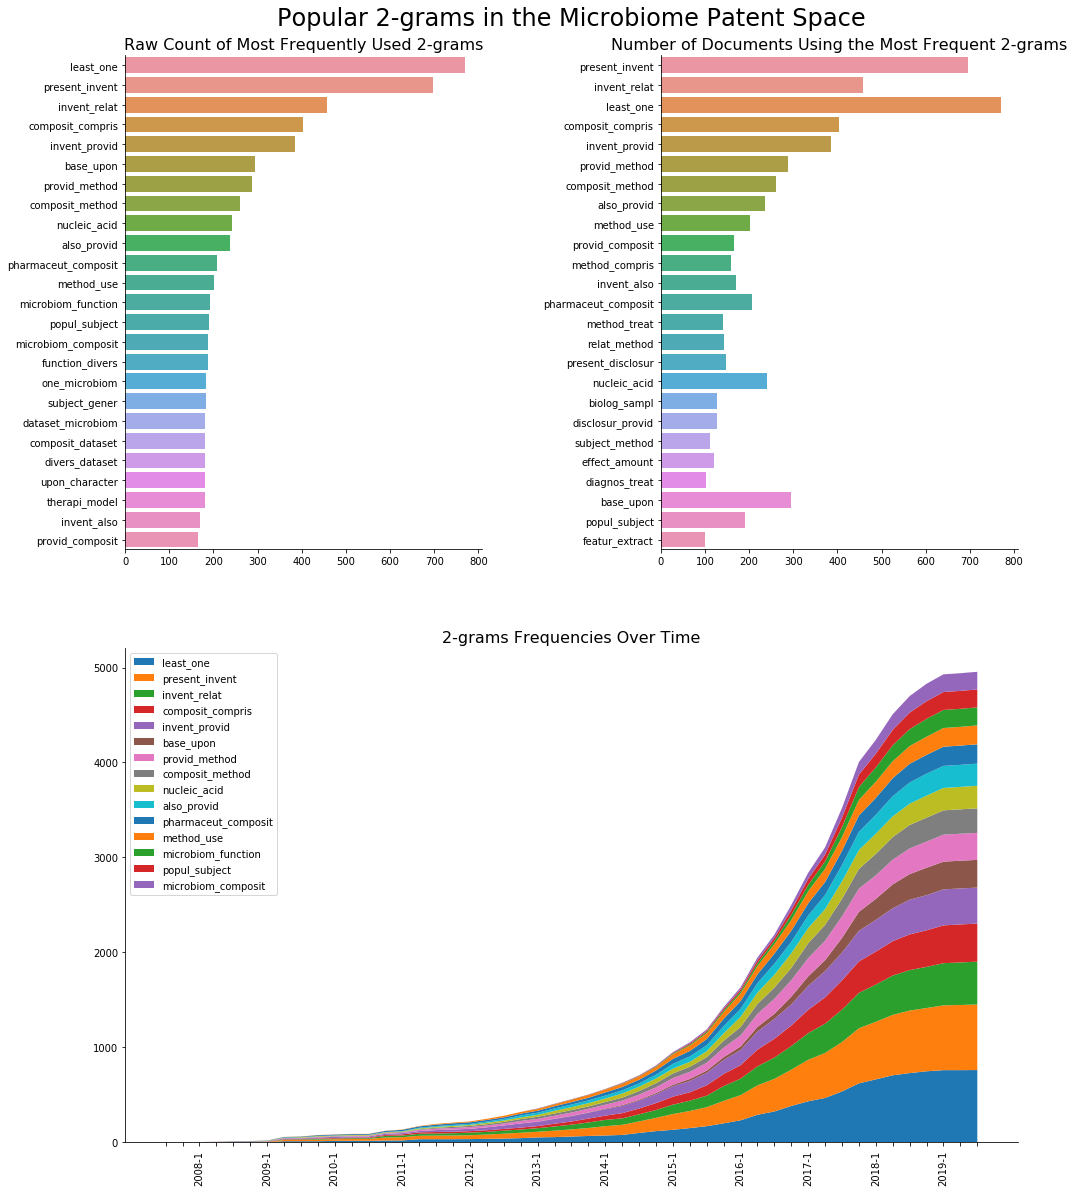

In [36]:
fig = plt.figure(figsize=(16,20), facecolor='white')
ax = fig.add_subplot(111, fc='white')    # The big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.5)
plt.title('Popular 2-grams in the Microbiome Patent Space', pad=30, fontsize=24)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1,:])
sns.despine()

sns.barplot(top_2gram_count_list, top_2gram_list, ax=ax1)
sns.barplot(top_2gramdf_count_list, top_2gramdf_list, ax=ax2, orient='horizontal')
x_values = []
labels = []
for term, term_dict in common_2grams_by_time.items():
    x_values.append(list(term_dict.values()))
    labels.append(term)
    y_values = common_2grams_by_time[term].keys()

ax3.stackplot(y_values, x_values, labels=labels)
ax3.set_xticklabels(labels = list(term_dict.keys()), rotation=90)
for index, label in enumerate(ax3.xaxis.get_ticklabels()):
    if index % 4 != 2:
        label.set_visible(False)
ax1.set_title('Raw Count of Most Frequently Used 2-grams', fontsize=16)
ax2.set_title('Number of Documents Using the Most Frequent 2-grams', fontsize=16)
ax3.set_title('2-grams Frequencies Over Time', fontsize=16)
ax3.legend(loc='upper left')


plt.show()

#### 3-grams

##### Top 3-Gram Lists

In [37]:
n = 25
top_3gram_list = sorted(freq_dicts['3'], key=freq_dicts['3'].get, reverse=True)[:n]
top_3gram_count_list = [freq_dicts['3'][i] for i in top_3gram_list]

n = 25
top_3gramdf_list = sorted(df_dicts['3'], key=df_dicts['3'].get, reverse=True)[:n]
top_3gramdf_count_list = [freq_dicts['3'][i] for i in top_3gramdf_list]

##### 3-Gram Year-Quarter Corpuses

In [38]:
ngram_3_text_year_quarter = {}
ngram_3_count_year_quarter = {}
for abstract, year_quarter in zip(ngrams_3, pub_quarters):
    if year_quarter not in ngram_3_text_year_quarter.keys():
        ngram_3_text_year_quarter[year_quarter] = abstract
        ngram_3_count_year_quarter[year_quarter] = 1
    else:
        ngram_3_text_year_quarter[year_quarter] += abstract
        ngram_3_count_year_quarter[year_quarter] += 1

##### Common 3-Grams Over Time

In [39]:
common_3grams_by_time = {}   
for common_term in top_3gram_list[:15]:
    word_count = 0
    common_3grams_by_time[common_term] = {}
    for year_quarter in sorted(ngram_3_text_year_quarter.keys()):
        
        for word in ngram_3_text_year_quarter[year_quarter]:
            if common_term == word:
                word_count += 1
                continue
        common_3grams_by_time[common_term][year_quarter] = word_count

##### Plot

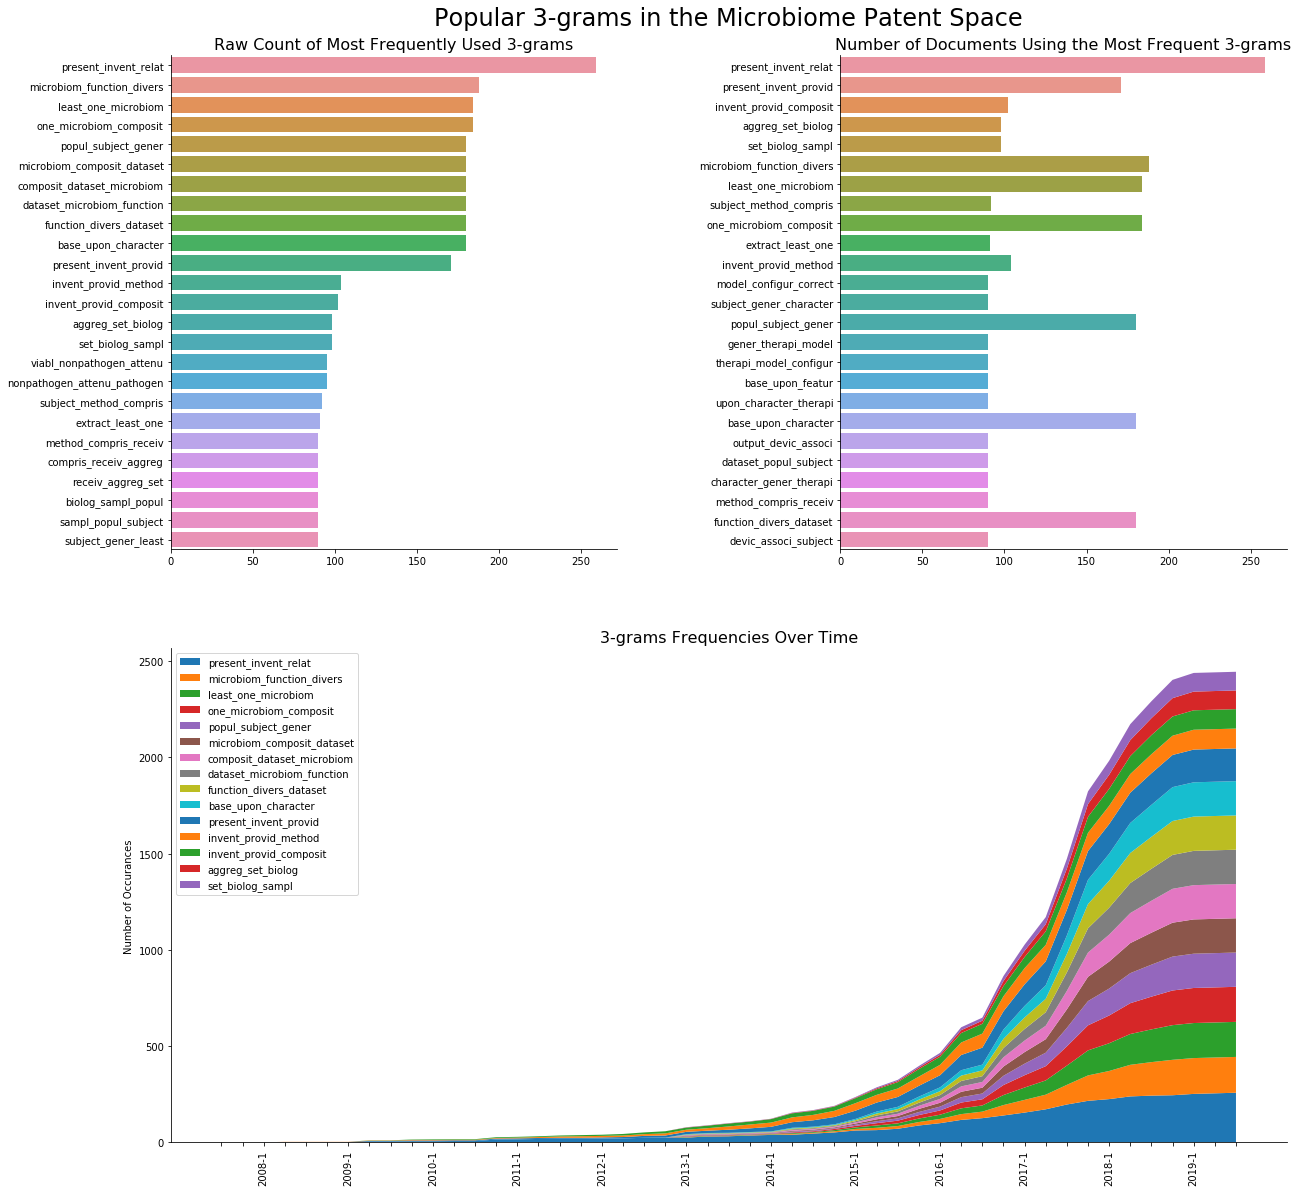

In [40]:
fig = plt.figure(figsize=(20,20), facecolor='white')
ax = fig.add_subplot(111, fc='white')    # The big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.5)
plt.title('Popular 3-grams in the Microbiome Patent Space', pad=30, fontsize=24)
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1,:])
sns.despine()

sns.barplot(top_3gram_count_list, top_3gram_list, ax=ax1)
sns.barplot(top_3gramdf_count_list, top_3gramdf_list, ax=ax2, orient='horizontal')
x_values = []
labels = []
for term, term_dict in common_3grams_by_time.items():
    x_values.append(list(term_dict.values()))
    labels.append(term)
    y_values = common_3grams_by_time[term].keys()

ax3.stackplot(y_values, x_values, labels=labels)
ax3.set_xticklabels(labels = list(term_dict.keys()), rotation=90)
ax3.set_ylabel('Number of Occurances')
for index, label in enumerate(ax3.xaxis.get_ticklabels()):
    if index % 4 != 2:
        label.set_visible(False)
ax1.set_title('Raw Count of Most Frequently Used 3-grams', fontsize=16)
ax2.set_title('Number of Documents Using the Most Frequent 3-grams', fontsize=16)
ax3.set_title('3-grams Frequencies Over Time', fontsize=16)
ax3.legend(loc='upper left')


plt.show()

### TF-IDF Words 

In [ ]:
tf_dicts = {}

for ngram, list_of_grams in [('1', fil_abstracts), ('2', ngrams_2), ('3', ngrams_3)]:
    for document in list_of_grams:
        for gram in document:
            if gram not in document_dict.keys():
                document_dict[gram] = 1
            else:
                document_dict[gram] += 1
    


In [ ]:

x_values = []
labels = []
for term, term_dict in common_3grams_by_time.items():
    x_values.append(list(term_dict.values()))
    labels.append(term)
    y_values = common_3grams_by_time[term].keys()